In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import json

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import metrics

# Load ultimate_data_challenge.json as DataFrame
with open('ultimate_data_challenge.json') as datafile:
    data = json.load(datafile)
df = pd.DataFrame(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [2]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [3]:
def city_num(x):
    if x == "King's Landing":
        x = 1
    elif x == "Astapor":
        x = 2
    else:
        x = 3
    return x

df['city_num'] = df['city'].apply(city_num)

# Change data types for "signup_date" and "last_trip_date" columns to DateTime values
df.signup_date = pd.to_datetime(df.signup_date)
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df['length_of_membership'] = df.last_trip_date - df.signup_date
df['length_of_membership'] = df['length_of_membership'].dt.days

# Create new column to define if a user is "active" (i.e. 1 for "last_trip_date" within 
# the last 30 days of the user's last trip date, 0 otherwise)
latest = df.last_trip_date.max()
df['IsActiveUser'] = df.last_trip_date.apply(lambda x: 1 if ((latest - x) > datetime.timedelta(days=30))  else 0)

# Create new column to convert "phone" column to boolean (i.e. 1 for iPhone, 0 for Android)
df['phone_bool'] = df.phone.apply(lambda x: 1 if x == "iPhone" else 0)

# Create new column to convert "ultimate_black_user_bool" column to boolean (i.e. 1 for True, 0 for False)
df['ultimate_black_user_bool'] = df.ultimate_black_user.apply(lambda x: 1 if x == True else 0)

# Create new column to determine the month of "last_trip_date"
df['month_last_trip'] = df.last_trip_date.dt.month

# Create new column to determine the day of "last_trip_date"
df['day_last_trip'] = df.last_trip_date.dt.dayofweek

df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_num,length_of_membership,IsActiveUser,phone_bool,ultimate_black_user_bool,month_last_trip,day_last_trip
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1,143,0,1,1,6,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,2,96,1,0,0,5,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,2,1,1,1,0,1,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1,170,0,1,1,6,6
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,3,47,1,0,0,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,1,131,0,1,0,6,3
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0,2,1,1,1,0,1,5
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,3,111,1,0,1,5,3
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5,2,1,1,1,0,1,2


In [4]:
# Approx 62% of riders are retained as Active
(df[df.IsActiveUser == 1].shape[0])/(df.shape[0])

0.62392

C:\Users\Joe\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Joe\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


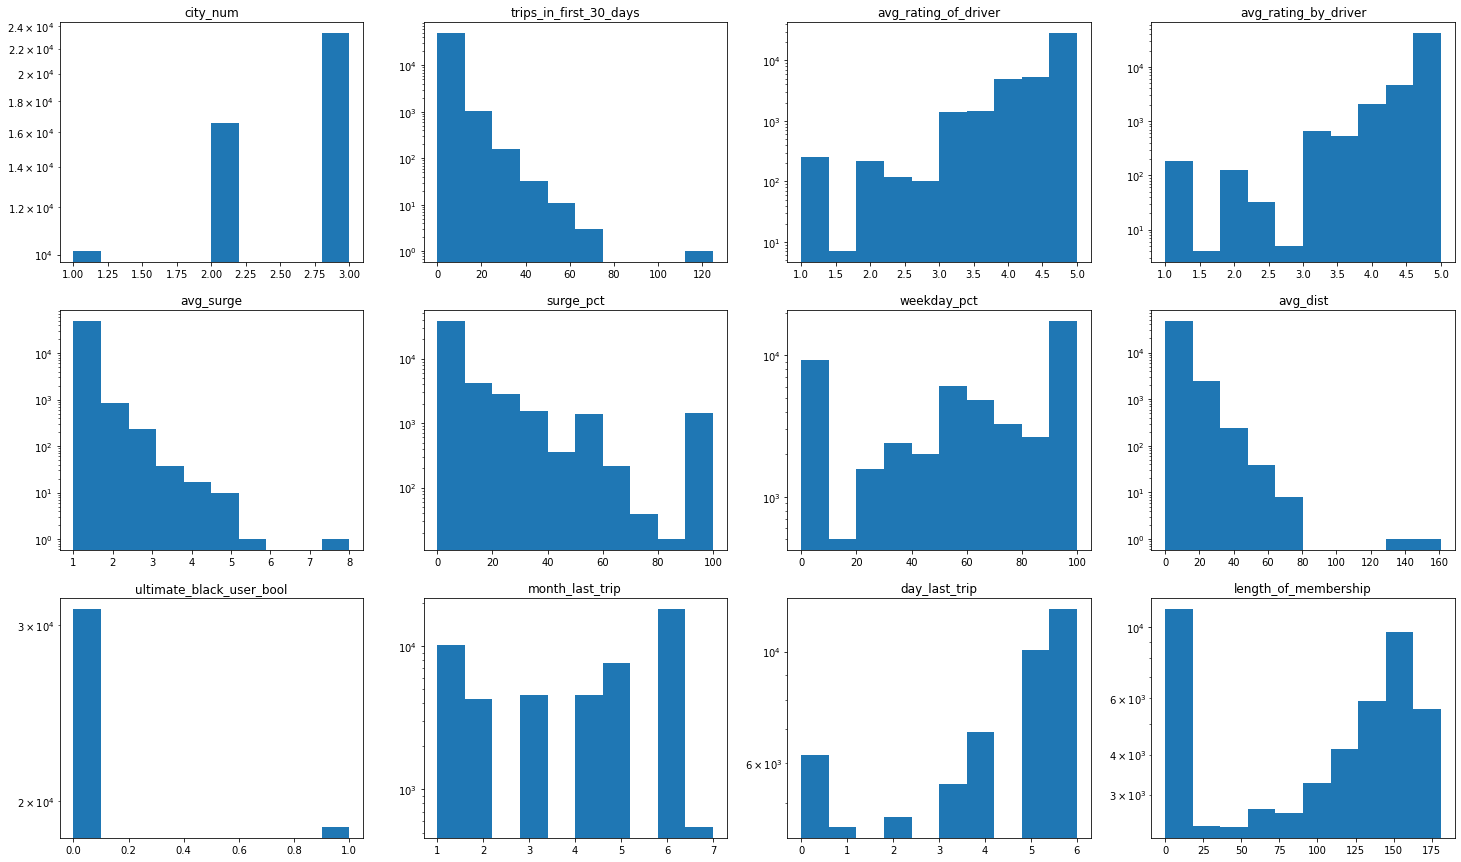

In [5]:
data_EDA = df[['city_num', 'trips_in_first_30_days','avg_rating_of_driver',
       'avg_rating_by_driver','avg_surge', 'surge_pct',
        'weekday_pct', 'avg_dist','ultimate_black_user_bool',
        'month_last_trip','day_last_trip','length_of_membership']]

fig,i = plt.subplots(3,4,figsize=(25,15))
n = 0
for a in range(3):
    for b in range(4):
        i[a][b].hist(data_EDA.iloc[:,n],log=True)
        i[a][b].set_title(data_EDA.columns[n])
        n += 1

plt.show()

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


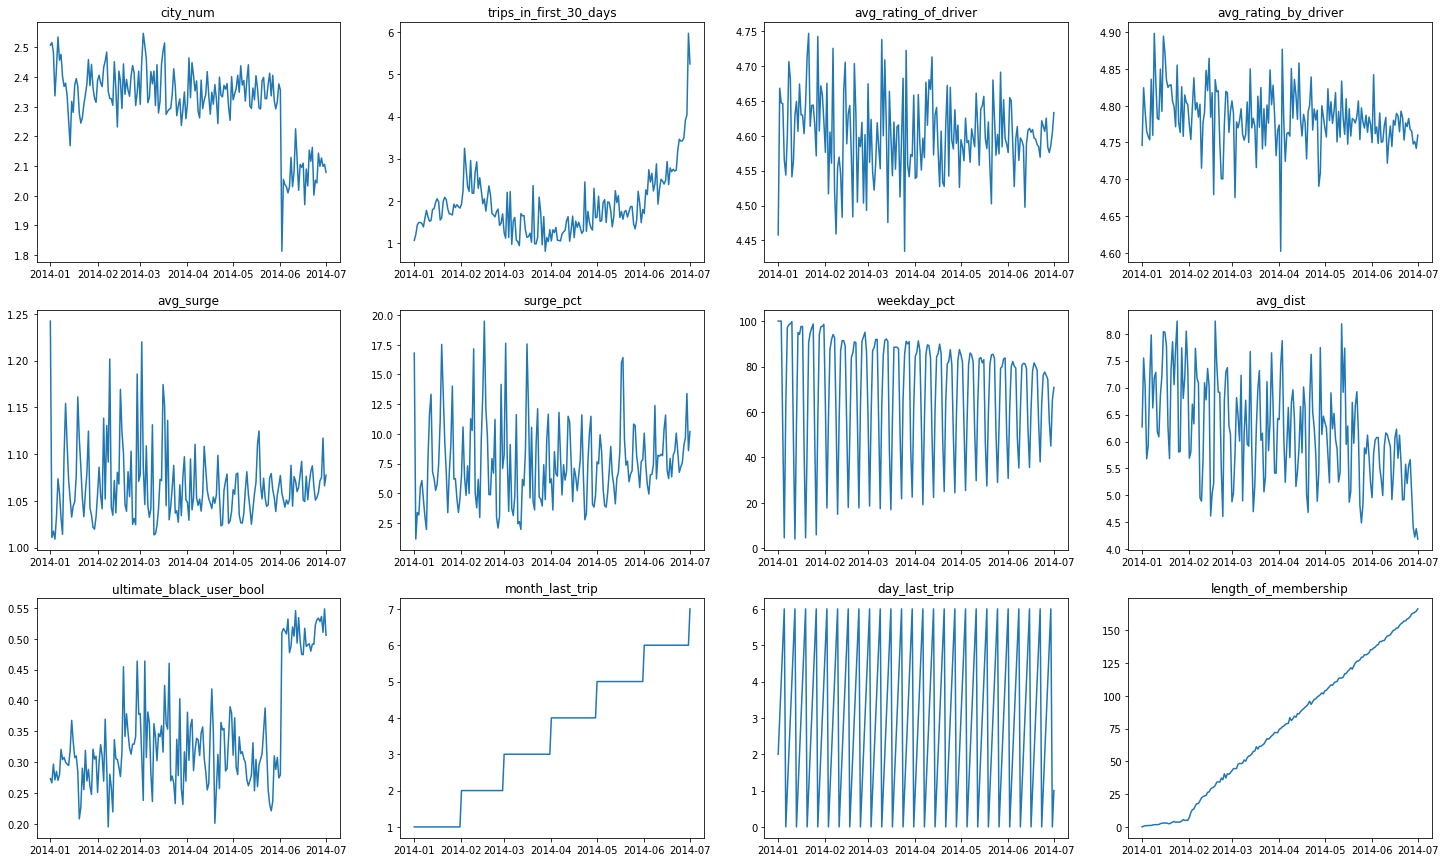

In [6]:
avgs = df.groupby('last_trip_date').mean().loc[:,data_EDA.columns]
fig,i = plt.subplots(3,4,figsize=(25,15))
n = 0
for a in range(3):
    for b in range(4):
        i[a][b].plot(avgs.iloc[:,[n]])
        i[a][b].set_title(data_EDA.columns[n])
        n += 1

plt.show()

In [7]:
avgs.reset_index(inplace=True)
avgs

,last_trip_date,city_num,trips_in_first_30_days,avg_rating_of_driver,avg_rating_by_driver,avg_surge,surge_pct,weekday_pct,avg_dist,ultimate_black_user_bool,month_last_trip,day_last_trip,length_of_membership
0,2014-01-01,2.507812,1.062500,4.457746,4.746094,1.242188,16.796875,100.000000,6.271797,0.273438,1.0,2.0,0.000000
1,2014-01-02,2.516667,1.200000,4.668254,4.824444,1.010889,1.147778,100.000000,7.548722,0.266667,1.0,3.0,0.566667
2,2014-01-03,2.484375,1.429688,4.647126,4.792063,1.017578,3.385156,100.000000,7.010312,0.296875,1.0,4.0,0.859375
3,2014-01-04,2.336683,1.487437,4.646309,4.765327,1.009095,3.182412,51.615075,5.680050,0.271357,1.0,5.0,1.020101
4,2014-01-05,2.429630,1.485185,4.565405,4.758364,1.032630,5.555556,4.651852,5.921111,0.285185,1.0,6.0,1.059259
...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,2014-06-27,2.099107,3.495536,4.583654,4.765385,1.071545,9.017946,74.400000,5.055223,0.527679,6.0,4.0,162.548214
178,2014-06-28,2.127457,3.911852,4.575879,4.747974,1.074812,9.703871,55.874628,4.409208,0.536033,6.0,5.0,163.117927
179,2014-06-29,2.099214,4.036837,4.586340,4.751402,1.117137,13.401375,45.039489,4.227358,0.510314,6.0,6.0,163.746562
180,2014-06-30,2.105824,5.973722,4.604237,4.741974,1.066101,8.589560,65.170099,4.383835,0.548295,6.0,0.0,164.615767


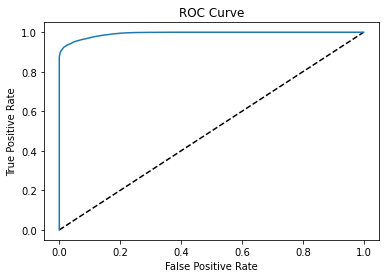

In [17]:
# Drop all rows that contain null values
df=df.dropna()

# Define X and y data sets
# X = df[['city_num', 'trips_in_first_30_days','avg_rating_of_driver',
#        'avg_rating_by_driver','avg_surge', 'surge_pct',
#         'weekday_pct', 'avg_dist','ultimate_black_user_bool',
#         'length_of_membership']]

X = df[['length_of_membership']]

y = df['IsActiveUser']

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Create the classifier: logreg
lr = LogisticRegression()

# Setup the parameters and distributions to sample from: param_dist
param_dist = {'solver':['newton-cg', 'lbfgs'],
              'n_jobs':[4,5,6],
              'max_iter':[900,1000,1100]}

# Instantiate the RandomizedSearchCV object: tree_cv
logreg = RandomizedSearchCV(lr, param_dist, cv=5)

# Fit the classifier to the training data
logreg.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [18]:
metrics.roc_auc_score(y_test, y_pred_prob) # AUC

0.9929205109188404

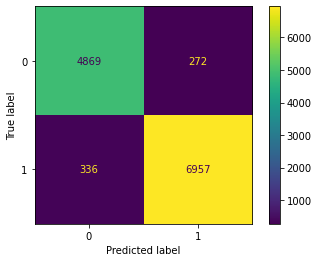

In [19]:
plot_confusion_matrix(logreg, X_test, y_test)  

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      5141
           1       0.96      0.95      0.96      7293

    accuracy                           0.95     12434
   macro avg       0.95      0.95      0.95     12434
weighted avg       0.95      0.95      0.95     12434



In [21]:
logreg.best_params_

{'solver': 'newton-cg', 'n_jobs': 5, 'max_iter': 900}

In [22]:
model = LogisticRegression(solver = 'lbfgs', 
                           n_jobs = 5, 
                           max_iter = 900)

model.fit(X_train,y_train)

feature_importances = pd.DataFrame(model.coef_[0],
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)
feature_importances

,importance
length_of_membership,-0.213027


In [23]:
model.predict(X_test).sum() / len(X_test)

0.5813897378156667

In [25]:
# Assume that each column of data can be generalized by a linear fit and obtain slope/intercept for each column

slopes = dict.fromkeys(X.columns)
intercepts = dict.fromkeys(X.columns)

for col in X.columns:
    slope, intercept = np.polyfit(avgs.index, avgs[col], deg=1)
    slopes[col] = slope
    intercepts[col] = intercept 
    
linFit_df = pd.DataFrame.from_dict(slopes,
                             orient = 'index',
                             columns=['slopes'])#.sort_values('slopes',ascending=False)

intercepts_df = pd.DataFrame.from_dict(intercepts,
                             orient = 'index',
                             columns=['intercepts'])#.sort_values('intercepts',ascending=False)

linFit_df['intercepts'] = intercepts_df
linFit_df['6-mth_pred'] = (linFit_df.slopes*180) + linFit_df.intercepts
linFit_df

,slopes,intercepts,6-mth_pred
length_of_membership,0.985723,-14.217699,163.212391


In [26]:
x = sum(linFit_df['6-mth_pred'] * feature_importances['importance']) + model.intercept_

# Almost no chance a user will remain active after 6 months in the system
print('{:.2f}% chance'.format(100 * (1 / (1 + np.exp(-x[0]))))) 

0.18% chance


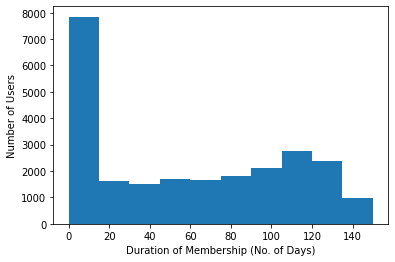

In [27]:
plt.hist(df[df.IsActiveUser == 1].length_of_membership)
plt.ylabel('Number of Users')
plt.xlabel('Duration of Membership (No. of Days)')
plt.show()

In [28]:
series = df[df.IsActiveUser == 1].length_of_membership
series.sort_values(ascending=False)

6789     150
13136    150
12869    150
27120    150
29588    150
        ... 
17963      0
2155       0
35883      0
17952      0
48161      0
Name: length_of_membership, Length: 24410, dtype: int64